In [ ]:
"""
Created on Fri Jan 29 22:40:08 2021

@author: paulb
"""

'\nCreated on Fri Jan 29 22:40:08 2021\n\n@author: paulb\n'

# Import des bibliothèques

In [1]:
import sys
import cython

import numba
from numba import jit

import numpy as np
import pandas as pd
import math
import logging
import threading
import time
import matplotlib.pyplot as plt

In [2]:
numba.__version__,   np.__version__,   cython.__version__,   sys.version

('0.51.2',
 '1.19.5',
 '0.29.27',
 '3.7.12 (default, Jan 15 2022, 18:48:18) \n[GCC 7.5.0]')

# Chargement des données

In [3]:
def extract_coord(geostring : str):
    where=geostring.find(',')
    return[float(geostring[:where]),float(geostring[where+1:])]

In [4]:
%load_ext Cython

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

path_paul='/content/drive/MyDrive/éléments logiciels/Elements_Logiciels_ENSAE-main/'
data=pd.read_csv(path_paul+'annonces_immo.csv')
data=data[['approximate_latitude','approximate_longitude']]
data.columns = ['latitude', 'longitude']

df_gare=pd.read_csv(path_paul+'referentiel-gares-voyageurs.csv',sep=';')
#Suppression des 11 gares sans coordonnéées GPS
df_gare=df_gare[df_gare['WGS 84'].isnull()== False]

gareratp=pd.read_csv(path_paul+'emplacement-des-gares-idf.csv',sep=';')
gareratp["latitude"]=gareratp.apply(
    lambda x: extract_coord(x['Geo Point'])[0],
    axis=1)
gareratp["longitude"]=gareratp.apply(
    lambda x: extract_coord(x['Geo Point'])[1],
    axis=1)

df_gare2=df_gare[['Latitude','Longitude','WGS 84']]
gareratp2=gareratp[['latitude','longitude','Geo Point']]
df_gare2.columns=gareratp2.columns

#concatenation des DataFrame SNCF & RATP
df_train=pd.concat([df_gare2,gareratp2],ignore_index=True)
df_train.drop_duplicates(inplace=True) #Suppresion des gares en doublon en IDF

df_train.drop('Geo Point', axis=1, inplace=True)

elem_max = 5000
df_orig = data[:elem_max].copy()

elem_max2=1000
#df_dest = df_train[:elem_max2].copy()
df_dest = df_train.copy()

# Cython OK

In [7]:
%%cython -a

from cython cimport boundscheck, wraparound
from cython.parallel cimport prange

import numpy as np
import pandas as pd
import time as time 
import math as math

from libc.math cimport sin, cos, sqrt, atan2, M_PI
#from libc.time cimport time,time_t
from posix.time cimport clock_gettime, timespec, CLOCK_REALTIME


cimport numpy as np

cdef double radia(double omega) nogil:
  return omega*M_PI/180 

@boundscheck(False)
@wraparound(False)
cdef double distance2_cy(double lat1, double lon1,double lat2,double lon2) nogil:
    cdef: 
      double dlat, dlon, a, c, d, radius

    radius = 6371  # km

    dlat = radia(lat2 - lat1)
    dlon = radia(lon2 - lon1)
    a = (sin(dlat / 2) * sin(dlat / 2) +
         cos(radia(lat1)) * cos(radia(lat2)) *
         sin(dlon / 2) * sin(dlon / 2))
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    d = radius * c
    return d

@boundscheck(False)
@wraparound(False)
cdef double[:, ::1] CalculDistance_thread_cy(double[:, ::1] orig, double[:, ::1] dest, double[:, ::1] res) nogil:
    
    cdef:
      int raw, col, i, j
      double lat1, lon1, lat2, lon2
      
    raw=orig.shape[0]
    col=dest.shape[0]

    for i in range(0,raw):
        lat1=orig[i,0]
        lon1=orig[i,1]
        for j in range(0,col):
            lat2=dest[j,0]
            lon2=dest[j,1]
            res[i,j]=distance2_cy(lat1,lon1,lat2,lon2)
    return res


@boundscheck(False)
@wraparound(False)
def Distance_parallelized_cy(origin :pd.DataFrame, destination :pd.DataFrame, int resolution =2):
    
    cdef: 
        int r, i, j
        double[:, :, ::1] results
        double[:, ::1] origin_arr, dest_arr, res_input
        int[::1] index_a, index_b 
        #time_t t = time(NULL) 
    cdef: 
        timespec ts
        double start, exec_time
    
    # Création des doubles

    N = origin.shape[0]
    index_a = np.zeros((resolution), dtype=np.int32)
    index_b = np.zeros((resolution), dtype=np.int32)
    for i in range(resolution):
      index_a[i] = N // resolution * i
      index_b[i] = N // resolution * (i + 1)
    
    origin_arr = np.zeros((origin.shape[0],origin.shape[1]))
    for i in range(0, origin.shape[0]):
      for j in range(0, origin.shape[1]):
        origin_arr[i,j]=origin.to_numpy()[i,j]

    dest_arr = np.zeros((destination.shape[0],destination.shape[1]))
    for i in range(0, destination.shape[0]):
      for j in range(0, destination.shape[1]):
        dest_arr[i,j]=destination.to_numpy()[i,j]
      
    res_input = np.zeros((origin.shape[0],destination.shape[0]))
    
    results = np.zeros((resolution, N, destination.shape[0]))

    clock_gettime(CLOCK_REALTIME, &ts)
    start = ts.tv_sec + (ts.tv_nsec / 1000000000.)
    #start = time(NULL)
    
    # Parallel
    #for r in prange(resolution + 1, nogil=True): # VOIR DIFF
    for r in prange(resolution + 1, nogil=True,
                    schedule='static', chunksize=1, num_threads = resolution):
        results[r,index_a[r]:index_b[r],:] = CalculDistance_thread_cy(origin_arr[index_a[r]:index_b[r]], dest_arr, res_input[index_a[r]:index_b[r],:])
    
    clock_gettime(CLOCK_REALTIME, &ts)
    exec_time = ts.tv_sec + (ts.tv_nsec / 1000000000.) - start
    df_final = pd.DataFrame([])

    for r in range(0,resolution):
        df_results =  pd.DataFrame(np.asarray(results[r,index_a[r]:index_b[r],:]))
        df_final=pd.concat([df_final,df_results])
    df_final.reset_index(drop=True, inplace=True)
    # np.array([df_final, exec_time_threads, exec_time, com_time, launch_time], dtype=object)
    return np.array([df_final, exec_time], dtype=object)

In [ ]:
t1 = %timeit res = Distance_parallelized_cy(df_orig, df_dest, 2)

1 loop, best of 5: 2.45 s per loop


In [ ]:
res = Distance_parallelized_cy(df_orig, df_dest, 2)

In [ ]:
from google.colab import files


In [ ]:
#Multithreading !
nb_threads=np.logspace(1,5,5, base=2)
time_exec=[]
time_creation_to_exec=[]
for nb_thread in nb_threads:
    print("Multithreading starting for {} Threads".format(int(nb_thread)))
    t=time.time()
    res = Distance_parallelized_cy(df_orig, df_dest, int(nb_thread))
    time_exec.append(res[1])
    t2=time.time()-t
    #pd.DataFrame(res[0].transpose().min()).to_excel('MultiProcess_N_'+str(nb_thread)+'.xlsx')
    #files.download('MultiProcess_N_'+str(nb_thread)+'.xlsx')
    del res #Libérer de la mémoire
    print("Temps d'éxécution pour gares (Threads {}: {} secondes".format(int(nb_thread),round(t2, 2)))

Multithreading starting for 2 Threads
Temps d'éxécution pour gares (Threads 2: 2.51 secondes
Multithreading starting for 4 Threads
Temps d'éxécution pour gares (Threads 4: 2.36 secondes
Multithreading starting for 8 Threads
Temps d'éxécution pour gares (Threads 8: 2.56 secondes
Multithreading starting for 16 Threads
Temps d'éxécution pour gares (Threads 16: 3.37 secondes
Multithreading starting for 32 Threads
Temps d'éxécution pour gares (Threads 32: 4.83 secondes


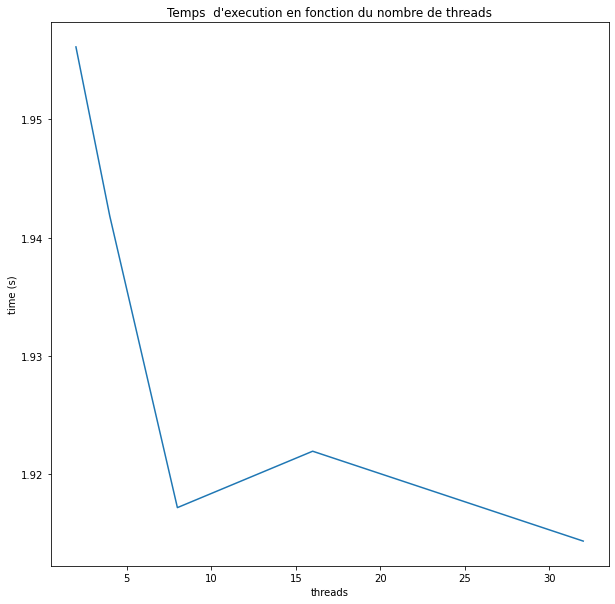

Fin


In [ ]:
fig=plt.figure(figsize=(10,10))
plt.plot(nb_threads,time_exec)
plt.xlabel('threads')
plt.ylabel('time (s)')
plt.title("Temps  d'execution en fonction du nombre de threads")
plt.show()

print('Fin')

In [ ]:
import psutil

print('Ram:',psutil.virtual_memory()[0]/10**9,'GB')
print('Cpu Count:',psutil.cpu_count())
# you can have the percentage of used RAM
print('% of Used RAM:',psutil.virtual_memory().percent)
# you can calculate percentage of available memory
print('percentage of available memory',psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

Ram: 13.622181888 GB
Cpu Count: 2
% of Used RAM: 12.8
percentage of available memory 87.18743685593049


In [ ]:
pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=90830ebb900f90ec163830d54d222db0acdcd16e1d8200a0c4207d6d56ef7158
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [ ]:
from memory_profiler import memory_usage

#Multithreading !
nb_threads=np.logspace(1,5,5, base=2)
memory_used=[]
for nb_thread in nb_threads:
    print("Multithreading starting for {} Threads".format(int(nb_thread)))
    memo = memory_usage((Distance_parallelized_cy, (df_orig, df_dest, int(nb_thread))), interval=0.01)
    memory_used.append([memo])

Multithreading starting for 2 Threads
Multithreading starting for 4 Threads
Multithreading starting for 8 Threads
Multithreading starting for 16 Threads
Multithreading starting for 32 Threads


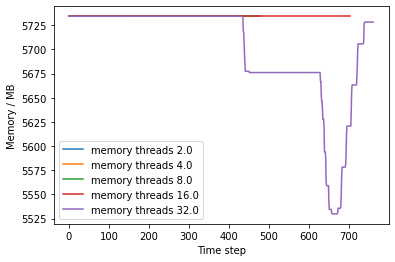

In [ ]:

# Plot results
for i in range(0,5):
    name='memory threads '+str(nb_threads[i])
    plt.plot(memory_used[i][0], label=name)
plt.xlabel('Time step')
plt.ylabel('Memory / MB')
plt.legend()
plt.show()